# EBSD Phase Map — Black Pixel Inpainting via Morphological Dilation

This notebook fills unresolved (black) pixels in an EBSD two-phase map  
using **competitive iterative dilation**: red and blue phases expand simultaneously,  
each only claiming pixels that were originally black.

In [1]:
# ── 0. Dependencies ────────────────────────────────────────────────────────────
# pip install numpy pillow opencv-python matplotlib  (if not already installed)
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [4]:
# ── 1. Parameters — adjust here ────────────────────────────────────────────────
IMAGE_PATH   = 'dss_2205/Project 2 Specimen 3 Site 1 Map Data 6-Ph.bmp'  # <-- change path if needed
OUTPUT_PATH  = 'dss_2205/EBSD_phase_filled_2.png'

# Map crop boundaries (pixels)
MAP_X_END    = 571   # right boundary of grain map (exclusive)
MAP_Y_END    = 392   # bottom boundary of grain map (exclusive)

# Dilation kernel size (3 = conservative, 5 = more aggressive)
KERNEL_SIZE  = 3

# Color thresholds
COLOR_THRESH = 20    # values below this are considered 0 (black detection)
PHASE_THRESH = 200   # values above this are considered fully saturated

In [5]:
# ── 2. Load image & crop map region ────────────────────────────────────────────
img_full = np.array(Image.open(IMAGE_PATH))
map_region = img_full[:MAP_Y_END, :MAP_X_END].copy()   # shape: (H, W, 3)

print(f'Full image size : {img_full.shape[1]} x {img_full.shape[0]} px')
print(f'Map region size : {map_region.shape[1]} x {map_region.shape[0]} px')

Full image size : 750 x 428 px
Map region size : 571 x 392 px


In [6]:
# ── 3. Build phase masks ────────────────────────────────────────────────────────
R, G, B = map_region[:,:,0], map_region[:,:,1], map_region[:,:,2]

# Red phase  : high R, low G, low B
red_mask  = (R > PHASE_THRESH) & (G < COLOR_THRESH) & (B < COLOR_THRESH)
# Blue phase : low R, low G, high B
blue_mask = (R < COLOR_THRESH) & (G < COLOR_THRESH) & (B > PHASE_THRESH)
# Black (unresolved) pixels
black_mask = (R < COLOR_THRESH) & (G < COLOR_THRESH) & (B < COLOR_THRESH)

total_map_px = map_region.shape[0] * map_region.shape[1]
print(f'Red pixels     : {red_mask.sum():>7}  ({100*red_mask.sum()/total_map_px:.2f}%)')
print(f'Blue pixels    : {blue_mask.sum():>7}  ({100*blue_mask.sum()/total_map_px:.2f}%)')
print(f'Black pixels   : {black_mask.sum():>7}  ({100*black_mask.sum()/total_map_px:.2f}%)')
print(f'Other pixels   : {(~red_mask & ~blue_mask & ~black_mask).sum():>7}')

Red pixels     :   88895  (39.72%)
Blue pixels    :  120609  (53.88%)
Black pixels   :   13565  (6.06%)
Other pixels   :     763


In [7]:
# ── 4. Competitive Iterative Dilation ──────────────────────────────────────────
#
# Strategy:
#   - Maintain two binary "claimed" arrays: claimed_red, claimed_blue
#   - Each iteration, dilate both; only allow expansion into still-black pixels
#   - If both phases try to claim the same pixel → first-come-first-served
#     (in practice, distance transform handles ties naturally)
#

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (KERNEL_SIZE, KERNEL_SIZE))

# Working masks (uint8 for OpenCV)
claimed_red  = red_mask.astype(np.uint8)
claimed_blue = blue_mask.astype(np.uint8)
remaining    = black_mask.copy()   # True = still needs to be filled

iteration = 0
while remaining.any():
    iteration += 1

    # Dilate each phase
    dil_red  = cv2.dilate(claimed_red,  kernel, iterations=1)
    dil_blue = cv2.dilate(claimed_blue, kernel, iterations=1)

    # New candidates: dilated into remaining black area
    new_red  = (dil_red  == 1) & remaining
    new_blue = (dil_blue == 1) & remaining

    # Conflict pixels claimed by both → assign to red (arbitrary tiebreak; rare)
    conflict = new_red & new_blue
    new_blue[conflict] = False   # red wins ties

    claimed_red[new_red]   = 1
    claimed_blue[new_blue] = 1

    # Remove newly claimed pixels from remaining
    remaining[new_red | new_blue] = False

    if iteration % 10 == 0:
        print(f'  iter {iteration:4d} | remaining black: {remaining.sum()}')

    # Safety: if no progress (isolated pixels completely surrounded by nothing)
    if not (new_red.any() or new_blue.any()):
        print(f'No progress at iteration {iteration}; stopping.')
        break

print(f'Done in {iteration} iterations. Remaining unfilled: {remaining.sum()}')

Done in 2 iterations. Remaining unfilled: 0


In [8]:
# ── 5. Build filled map image ───────────────────────────────────────────────────
filled_map = map_region.copy()

# Paint filled pixels
newly_red  = (claimed_red  == 1) & black_mask   # only touch originally-black pixels
newly_blue = (claimed_blue == 1) & black_mask

filled_map[newly_red]  = [255,   0,   0]
filled_map[newly_blue] = [  0,   0, 255]

# If any pixel is still black (shouldn't happen), leave as-is
print('Pixels still black after fill:', remaining.sum())

Pixels still black after fill: 0


In [9]:
# ── 6. Compute final phase fractions ───────────────────────────────────────────
R2, G2, B2 = filled_map[:,:,0], filled_map[:,:,1], filled_map[:,:,2]

final_red  = (R2 > PHASE_THRESH) & (G2 < COLOR_THRESH) & (B2 < COLOR_THRESH)
final_blue = (R2 < COLOR_THRESH) & (G2 < COLOR_THRESH) & (B2 > PHASE_THRESH)
final_other = ~final_red & ~final_blue   # white borders, remaining noise, etc.

total_colored = final_red.sum() + final_blue.sum()
map_px = filled_map.shape[0] * filled_map.shape[1]

# Fraction of total map area
frac_red_map  = 100 * final_red.sum()  / map_px
frac_blue_map = 100 * final_blue.sum() / map_px

# Fraction of colored (red+blue) pixels only
frac_red_phase  = 100 * final_red.sum()  / total_colored
frac_blue_phase = 100 * final_blue.sum() / total_colored

print('─── Phase Fraction (of total map area) ───')
print(f'  Red  phase : {frac_red_map:.2f}%')
print(f'  Blue phase : {frac_blue_map:.2f}%')
print()
print('─── Phase Fraction (of red+blue only) ────')
print(f'  Red  phase : {frac_red_phase:.2f}%')
print(f'  Blue phase : {frac_blue_phase:.2f}%')

─── Phase Fraction (of total map area) ───
  Red  phase : 44.54%
  Blue phase : 55.11%

─── Phase Fraction (of red+blue only) ────
  Red  phase : 44.70%
  Blue phase : 55.30%


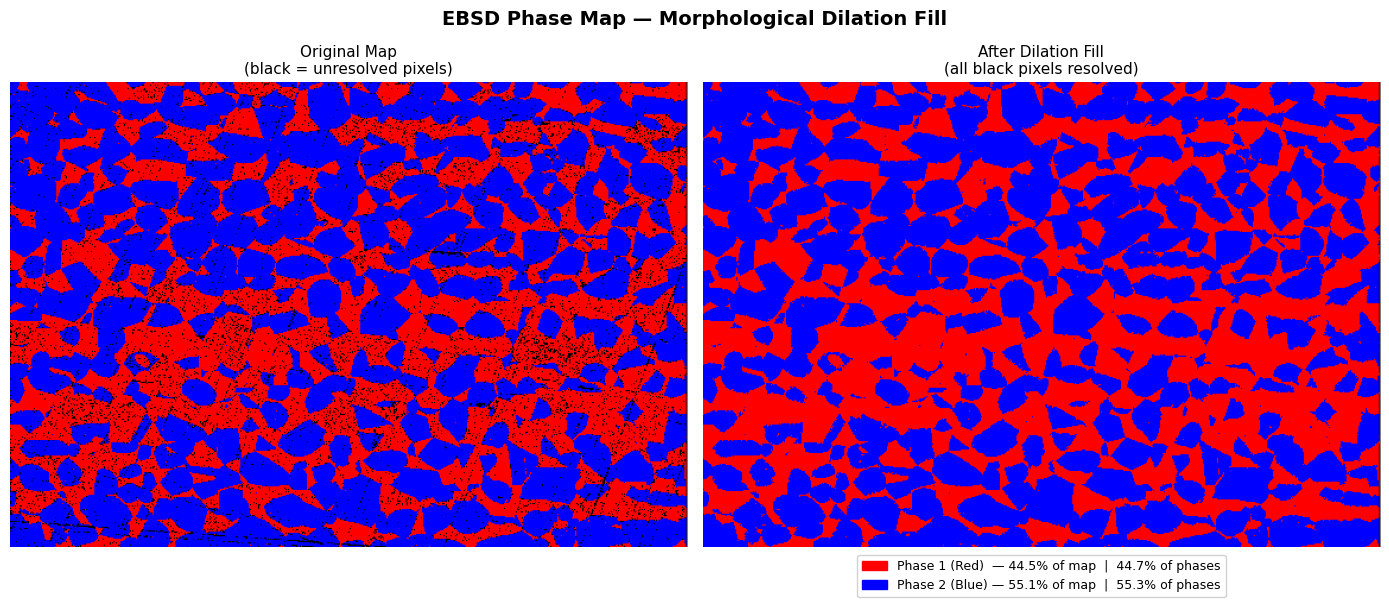

Saved → dss_2205/EBSD_phase_filled_2.png


In [10]:
# ── 7. Visualisation ───────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('EBSD Phase Map — Morphological Dilation Fill', fontsize=14, fontweight='bold')

# Left: original map
axes[0].imshow(map_region)
axes[0].set_title('Original Map\n(black = unresolved pixels)', fontsize=11)
axes[0].axis('off')

# Right: filled map
axes[1].imshow(filled_map)

# Build legend with fractions
patch_red  = mpatches.Patch(color='red',  label=f'Phase 1 (Red)  — {frac_red_map:.1f}% of map  |  {frac_red_phase:.1f}% of phases')
patch_blue = mpatches.Patch(color='blue', label=f'Phase 2 (Blue) — {frac_blue_map:.1f}% of map  |  {frac_blue_phase:.1f}% of phases')
axes[1].legend(handles=[patch_red, patch_blue],
               loc='lower center', bbox_to_anchor=(0.5, -0.12),
               fontsize=9, framealpha=0.9)
axes[1].set_title('After Dilation Fill\n(all black pixels resolved)', fontsize=11)
axes[1].axis('off')

plt.tight_layout()
plt.savefig(OUTPUT_PATH, dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved → {OUTPUT_PATH}')

In [11]:
# ── 8. (Optional) Save filled map only as a clean BMP ──────────────────────────
SAVE_CLEAN_MAP = True   # set False to skip

if SAVE_CLEAN_MAP:
    clean_path = OUTPUT_PATH.replace('.png', '_map_only.bmp')
    Image.fromarray(filled_map).save(clean_path)
    print(f'Clean map saved → {clean_path}')

Clean map saved → dss_2205/EBSD_phase_filled_2_map_only.bmp
